In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output, display

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

from pathlib import Path
#dirpath_root = Path('/content/drive/MyDrive/repo/pytorch_test')
dirpath_root = Path().resolve()

In [3]:
fname = 'rates_ws_1_nw_100_wsel_2_npts_5000_rmarg_0.01_seed_113'

data = xr.open_dataset(dirpath_root / 'data' / 'rates_2pop_1mat' / f'{fname}.nc')
print(data.sizes)

# Features
X = data['H']
X = torch.from_numpy(X.values).type(torch.float)

# Target
y = data['R']
y = torch.from_numpy(y.values).type(torch.float)

Frozen({'point': 2736, 'pop': 2})


In [4]:
df_x = pd.DataFrame(X.numpy(), columns=['h1', 'h2'])
df_y = pd.DataFrame(y.numpy(), columns=['r1', 'r2'])
df = pd.concat([df_x, df_y], axis=1)
df

,h1,h2,r1,r2
0,7.532477,3.103267,9.956944,6.746011
1,1.168321,0.123864,4.077924,9.375143
2,5.921931,3.340030,9.959578,3.256295
3,-3.603281,-4.380395,0.305240,7.075720
4,1.513275,1.855762,7.457316,8.820196
...,...,...,...,...
2731,11.554640,12.168859,9.987188,9.987862
2732,11.521655,12.286503,9.986972,9.988559
2733,11.424413,12.399865,9.986319,9.989194
2734,11.403275,12.463993,9.986172,9.989537


In [5]:
df.std(axis=0)

h1    5.504669
h2    5.389411
r1    4.168048
r2    4.448093
dtype: float32

In [ ]:
TORCH_SEED = 0
SPLIT_SEED = 0

torch.manual_seed(TORCH_SEED)

# Split into train and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SPLIT_SEED)

print(f'Train size: {X_train.shape} \nTest size: {X_test.shape}')

Train size: torch.Size([2188, 2]) 
Test size: torch.Size([548, 2])


In [5]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, n_layers=2, act=nn.GELU):
        super().__init__()
        layers = [nn.Linear(d_in, d_hidden), act()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(d_hidden, d_hidden), act()]
        layers += [nn.Linear(d_hidden, d_out)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class GatedKHeads(nn.Module):
    def __init__(self, d_in, d_out, hidden=128, trunk_layers=2, K=2):
        super().__init__()
        self.K = K
        self.trunk = MLP(d_in, hidden, hidden, n_layers=trunk_layers)
        # K expert heads (each outputs d_out numbers)
        self.experts = nn.ModuleList([MLP(hidden, hidden, d_out, n_layers=1)
                                      for _ in range(K)])
        # gate -> logits for K heads
        self.gate = MLP(hidden, hidden, K, n_layers=1)

    def forward(self, x):
        z = self.trunk(x)
        ys = torch.stack([torch.sigmoid(h(z)) * 10.0
                          for h in self.experts], dim=1)   # (B,K,d_out)
        logits = self.gate(z)                                  # (B,K)
        pi = F.softmax(logits, dim=-1)                         # (B,K)
        return ys, pi, logits

def loss_batch(yK, pi, logits, r_true,
               alpha=0.05, beta=0.0, lam=0.05, margin=0.3):
    # yK: (B,K,d_out), pi: (B,K), r_true: (B,d_out)
    dK = ((yK - r_true.unsqueeze(1))**2).mean(-1)             # (B,K)
    L_fit = (pi * dK).sum(dim=1).mean()

    # load-balance (KL to uniform)
    pi_bar = pi.mean(dim=0)                                    # (K,)
    L_bal = (pi_bar * (pi_bar.clamp_min(1e-8) * yK.size(1)).log()).sum()

    # optional hard gating CE (winner-take-all pseudo-label)
    if beta > 0:
        winners = dK.argmin(dim=1)
        L_ce = F.cross_entropy(logits, winners)
    else:
        L_ce = torch.zeros((), device=yK.device)

    # conditional diversity (hinge on pairwise distance when gate is unsure)
    # here K=2 for simplicity:
    if yK.size(1) == 2:
        D = torch.norm(yK[:,0,:] - yK[:,1,:], dim=-1)          # (B,)
        conf = pi.max(dim=1).values                            # (B,)
        L_div = ((1 - conf) * F.relu(margin - D)**2).mean()
    else:
        # generic K>2: pairwise distances + average (omit for brevity)
        print("Diversity loss not implemented for K > 2, using zero loss.")
        L_div = torch.zeros((), device=yK.device)

    loss = L_fit + alpha * L_bal + beta * L_ce + lam * L_div
    return loss, {'fit': L_fit.detach(), 'bal': L_bal.detach(),
                  'ce': L_ce.detach(), 'div': L_div.detach()}

In [6]:
def top1_mse(yK, r_true):
    # Best head by true distance (for evaluation only)
    dK = ((yK - r_true.unsqueeze(1))**2).mean(-1)  # (B,K)
    top1 = dK.min(dim=1).values
    return top1.mean()

@torch.no_grad()
def eval_epoch(model, X, y, batch_size=1024, device='cuda'):
    model.eval()
    n = X.size(0)
    tot_loss = 0.0
    tot_top1 = 0.0
    bal = 0.0
    tot_gate_entropy = 0.0
    steps = 0
    for i in range(0, n, batch_size):
        xb = X[i : i + batch_size].to(device, non_blocking=True)
        yb = y[i : i + batch_size].to(device, non_blocking=True)
        yK, pi, _ = model(xb)
        # Report top-1 MSE (closest head) as intuitive metric
        tot_top1 += top1_mse(yK, yb).item()
        # Report gated MSE (the same objective as training)
        dK = ((yK - yb.unsqueeze(1))**2).mean(-1)
        tot_loss += (pi * dK).sum(dim=1).mean().item()
        # Gate balance
        pi_bar = pi.mean(dim=0)
        bal += (pi_bar * (pi_bar.clamp_min(1e-8) * yK.size(1)).log()).sum()
        # Gate usage entropy (higher ~ balanced)
        ent = -(pi.clamp_min(1e-8) * pi.clamp_min(1e-8).log()).sum(dim=1).mean().item()
        tot_gate_entropy += ent
        steps += 1
    return {'gated_mse': tot_loss / steps,
            'top1_mse': tot_top1 / steps,
            'gate_balance': bal / steps,
            'gate_entropy': tot_gate_entropy / steps}

In [55]:
# Hyper-parameters
HIDDEN_SZ = 64
NLAYERS_HID = 2

n_feat = X.shape[1]
n_out = 2

# Define the model
model = GatedKHeads(n_feat, n_out, hidden=HIDDEN_SZ,
                    trunk_layers=NLAYERS_HID, K=2)
model = model.to(device)

In [56]:
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 2000
PRINT_EVERY = 20

ALPHA = 2   # head balance
BETA = 0
LAM = 1     # head diversity
MARGIN = 0.3

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Loader
dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    running_fit = 0
    running_total = 0
    n_seen = 0

    model.train()

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        yK, pi, logits = model(xb)

        loss, parts = loss_batch(
            yK, pi, logits, yb,
            alpha=ALPHA, beta=BETA, lam=LAM, margin=MARGIN
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_fit += parts['fit'].item() * xb.size(0)
        running_total += loss.item() * xb.size(0)
        n_seen += xb.size(0)

    train_fit = running_fit / n_seen
    train_total = running_total / n_seen

    if epoch % PRINT_EVERY == 0 or epoch == 1:
        mets_train = eval_epoch(model, X_train, y_train, device=device)
        mets_test = eval_epoch(model, X_test, y_test, device=device)
        print(
            f"ep {epoch:4d} | train_tot {train_total:.6f} | "
            #f"train_gated {train_fit:.6f} | "
            f"train_top1 {mets_train['top1_mse']:.6f} | "
            #f"train_bal {mets_train['gate_balance']:.4f} | "
            f"train_ent {mets_train['gate_entropy']:.4f} | "
            #f"val_gated {mets_test['gated_mse']:.6f} | "
            f"val_top1 {mets_test['top1_mse']:.6f} | "
            f"val_ent {mets_test['gate_entropy']:.4f}"
        )

ep    1 | train_tot 12.315381 | train_top1 8.796575 | train_ent 0.3430 | val_top1 9.101841 | val_ent 0.3595
ep   20 | train_tot 3.509196 | train_top1 3.092438 | train_ent 0.0557 | val_top1 4.462024 | val_ent 0.0518
ep   40 | train_tot 3.242130 | train_top1 2.543829 | train_ent 0.0143 | val_top1 3.986980 | val_ent 0.0162
ep   60 | train_tot 3.162479 | train_top1 2.178149 | train_ent 0.0140 | val_top1 3.425990 | val_ent 0.0144
ep   80 | train_tot 3.135897 | train_top1 1.922071 | train_ent 0.0128 | val_top1 2.811022 | val_ent 0.0165
ep  100 | train_tot 3.068638 | train_top1 1.783664 | train_ent 0.0103 | val_top1 2.563447 | val_ent 0.0113
ep  120 | train_tot 2.882288 | train_top1 1.749546 | train_ent 0.0117 | val_top1 2.691642 | val_ent 0.0102
ep  140 | train_tot 2.820855 | train_top1 1.617976 | train_ent 0.0120 | val_top1 2.519055 | val_ent 0.0127
ep  160 | train_tot 2.797622 | train_top1 1.891229 | train_ent 0.0079 | val_top1 2.823921 | val_ent 0.0095
ep  180 | train_tot 2.729246 | train

KeyboardInterrupt: 

In [11]:
import os

dirpath_out = dirpath_root / 'model' / 'rates_2pop_1mat' / fname
os.makedirs(dirpath_out, exist_ok=True)

# Save the trained model
fname_model = (
    f'nhid_{NLAYERS_HID}_szhid_{HIDDEN_SZ}_'
    f'batch_{BATCH_SIZE}_lr_{LR:.04f}_ep_{EPOCHS}_'
    f'alpha_{ALPHA}_beta_{BETA}_lam_{LAM}_marg_{MARGIN}_'
    f'split_{SPLIT_SEED}.pth'
)
fpath_model = dirpath_out / fname_model
torch.save(model.state_dict(), fpath_model)
print(f"Model saved to {fpath_model}")

Model saved to G:\Мой диск\repo\pytorch_test\model\rates_2pop_1mat\rates_ws_1_nw_100_wsel_2_npts_5000_rmarg_0.01_seed_113\nhid_2_szhid_64_batch_128_lr_0.0010_ep_2000_alpha_0.5_beta_0.1_lam_0.0_marg_0.3_split_0.pth


In [12]:
res = {
    'train': {'Xtens': X_train, 'ytens': y_train},   # pytorch tensors
    'test': {'Xtens': X_test, 'ytens': y_test}
}

# Apply trained todel to the train and test sets
model.eval()
with torch.inference_mode():
    for _, res_ in res.items():
        res_['yK'], res_['pi'], _ = model(res_['Xtens'])

# Pytorch tensors to numpy
for _, res_ in res.items():
    res_['yK'] = res_['yK'].cpu().numpy()
    res_['pi'] = res_['pi'].cpu().numpy()
    res_['X'] = res_['Xtens'].cpu().numpy()
    res_['y'] = res_['ytens'].cpu().numpy()

In [20]:
# Calculate error
for name, res_ in res.items():
    y_, yK_ = res_['y'], res_['yK']
    #err = np.sqrt(np.sum((rr - y) ** 2, axis=-1))
    err = np.sqrt(np.sum((y_.reshape((-1, 1, 2)) - yK_) ** 2, axis=-1)).min(axis=1)
    res_['err'] = err
    print(f'{name}:\t', np.round(err[:10], 4))

#y = np.zeros_like(rr)
#mask = pi[:, 0] > pi[:, 1]
#y[mask, :] = yK[mask, 0, :]
#y[~mask, :] = yK[~mask, 1, :]

#res = np.concatenate((rr, y), axis=1)
#print(np.round(res[:10, :], 3))

train:	 [0.1664 0.3568 0.9125 0.3588 0.9255 0.2315 0.8614 0.054  0.1553 0.0673]
test:	 [0.8748 0.4767 4.1698 0.3787 0.0275 0.0848 1.9389 0.0531 0.1936 0.4729]


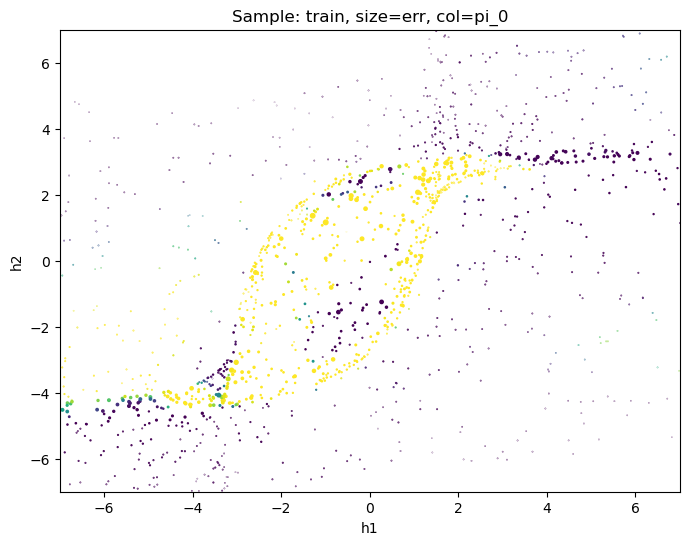

In [46]:
#pi_max = np.max(pi, axis=-1)

sample_name = 'train'
#sample_name = 'test'

res_ = res[sample_name]

#s = 1
s = res_['err']
#c = err
#s = pi_max * 5
#c = pi_max
#s = pi[:, 0] * 5
c = res_['pi'][:, 0]

plt.figure(figsize=(8, 6))
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
#plt.scatter(y_train[:, 0], y_train[:, 1], s=s, c=c)
#plt.xlabel('r1')
#plt.ylabel('r2')
#plt.colorbar()
#plt.subplot(1, 2, 2)
plt.scatter(res_['X'][:, 0], res_['X'][:, 1], s=s, c=c)
plt.xlabel('h1')
plt.ylabel('h2')
m = 7
plt.xlim(-m, m)
plt.ylim(-m, m)
#plt.colorbar(label='pi_0')
plt.title(f'Sample: {sample_name}, size=err, col=pi_0')
plt.show()

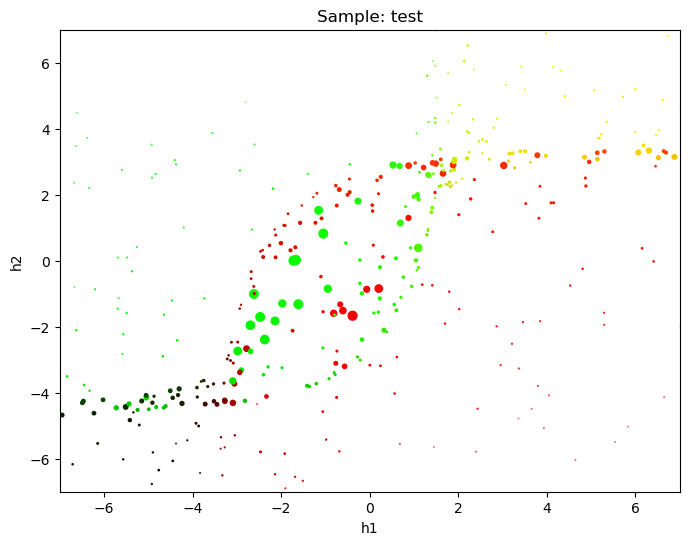

In [53]:
#sample_name = 'train'
sample_name = 'test'
res_ = res[sample_name]

cols = np.clip(res_['y'] / 10, 0, 1)
cols = np.hstack((cols, np.zeros((cols.shape[0], 1))))

#s = 2
s = res_['err'] * 3

plt.figure(figsize=(8, 6))
plt.scatter(res_['X'][:, 0], res_['X'][:, 1], s=s, c=cols)
plt.xlabel('h1')
plt.ylabel('h2')
m = 7
plt.xlim(-m, m)
plt.ylim(-m, m)
#plt.colorbar(label='pi_0')
plt.title(f'Sample: {sample_name}')
plt.show()